In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import argparse
import os.path as osp
import random
from multiprocessing import cpu_count

import tensorflow as tf

from rllab import config
from rllab.baselines.gaussian_mlp_baseline import GaussianMLPBaseline
from rllab.baselines.linear_feature_baseline import LinearFeatureBaseline
from rllab.baselines.zero_baseline import ZeroBaseline
from rllab.envs.normalized_env import normalize
from rllab.misc import logger
from rllab.misc.instrument import VariantGenerator
from rllab.misc.instrument import run_experiment_lite
from sandbox.carlos.point_env_randgoal import PointEnvRandGoal, StraightDemo
from sandbox.rocky.tf.algos.sensitive_lfd_trpo import SensitiveLfD_TRPO
from sandbox.rocky.tf.envs.base import TfEnv
from sandbox.rocky.tf.policies.sens_lfd_minimal_gauss_mlp_policy import SensitiveLfdGaussianMLPPolicy
from sandbox.rocky.tf.policies.gaussian_mlp_policy import GaussianMLPPolicy
from sandbox.young_clgan.logging import HTMLReport
from sandbox.young_clgan.logging import format_dict

/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/florensacc/anaconda2/envs/rllab-maml/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use

In [2]:
v={'env_noise': 0.1, 
   'tolerance': 0.1, 
   'fast_learning_rate': 0.001, 
   'max_path_length': 100, 
   'num_grad_updates': 1, 
   'meta_step_size': 0.01,
   'demo_batch_size': 1000,
   'batch_size': 1000,
   'discount': 0.99}

In [3]:
env = TfEnv(normalize(PointEnvRandGoal(noise=v['env_noise'], tolerance=v['tolerance'])))

policy = GaussianMLPPolicy(
    name='policy',
    env_spec=env.spec,
    hidden_nonlinearity=tf.nn.relu,
    hidden_sizes=(100, 100),
)

demo_policy = StraightDemo(env_spec=env.spec)

In [4]:
obs_demo_vars = env.observation_space.new_tensor_variable(
    'demo_obs',
    extra_dims=1,
    )
action_demo_vars = env.action_space.new_tensor_variable(
    'demo_actions',
    extra_dims=1,
    )

In [5]:
dist = policy.distribution

In [6]:
old_dist_info_demo_vars = {
    k: tf.placeholder(tf.float32, shape=[None] + list(shape), name='old_%s' % (k))
    for k, shape in dist.dist_info_specs
    }
old_dist_info_vars_demo_list = [old_dist_info_demo_vars[k] for k in dist.dist_info_keys] # list version of the dict

In [7]:
input_list = [obs_demo_vars, action_demo_vars]

dist_info_demo_vars = policy.dist_info_sym(obs_demo_vars)

params = policy.get_params_internal()

kl = dist.kl_sym(old_dist_info_demo_vars, dist_info_demo_vars)

logli_demo = dist.log_likelihood_sym(action_demo_vars, dist_info_demo_vars)

bc_loss = - tf.reduce_mean(logli_demo)
tf.summary.scalar('bc_loss', bc_loss)

<tf.Tensor 'bc_loss:0' shape=() dtype=string>

In [8]:
def update_dist_info_lfd_sym(surr_obj, params, step_size=0.01, update_param_keys=None):

    gradients = dict(
        zip(params, tf.gradients(surr_obj, [p for p in params])))
    new_params = dict(
        zip(params, [param - step_size * gradients[param] for param in params]))
    
    return new_params

In [9]:
step_size = 0.001 # define this as input to function

new_params = update_dist_info_lfd_sym(bc_loss, params, step_size)

new_dist_info_demo_vars = policy.dist_info_sym(obs_demo_vars)  # this does not create NEW vars!!
new_params = policy.get_params_internal()

In [10]:
# I should be done constructing the graph for the simple LFD update. Let's try it out!

In [11]:
from rllab.sampler.utils import rollout_demo
sess = tf.InteractiveSession()

goal = env.reset(clean_reset=True)
env.set_objective_params(goal)  # shouldn't need this

initializer = tf.global_variables_initializer()
sess.run(initializer)

demo = rollout_demo(env, demo_policy, v['max_path_length'])

resetting env_goal to:  [0 0]


In [12]:
# o = env.reset()
# print(o)
# policy.get_action(o)

In [13]:
# from rllab.sampler.utils import rollout
# pre_update = rollout(env, policy, v['max_path_length'])

In [14]:
input_list_dict = {obs_demo_vars : demo['observations'], action_demo_vars : demo['actions']}

In [15]:
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('data/tf_summaries/',
                                      sess.graph)

summary, bc_loss_val, new_params_vals = sess.run([merged, bc_loss, new_params], feed_dict=input_list_dict)

train_writer.add_summary(summary, 0)

In [16]:
print(tf.get_default_session())

In [17]:
bc_loss_val = sess.run(bc_loss, feed_dict=input_list_dict)
print('Loss after update %d: %f' % (0, bc_loss_val))
losses = []
for i in range(3000):  # for more steps I should 
    bc_loss_val, new_params_vals = sess.run([bc_loss, new_params], feed_dict=input_list_dict)
#     print('Loss after update %d: %f' % (i, bc_loss_val))
    policy.assign_params(policy.all_params, new_params_vals)
    losses.append(bc_loss_val)

Loss after update 0: 1.853411


AttributeError: 'GaussianMLPPolicy' object has no attribute 'assign_params'

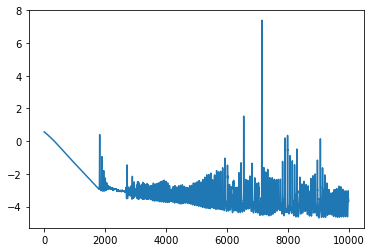

In [19]:
plt.plot(losses)

In [18]:
from rllab.sampler.utils import rollout
path = rollout(env, policy)

In [19]:
path

{'actions': array([[2.08274078, 0.83402768]]),
 'agent_infos': {'log_std': array([[0., 0.]], dtype=float32),
  'mean': array([[0., 0.]], dtype=float32)},
 'env_infos': {'goal': array([[0, 0]]), 'goal_reached': array([ True])},
 'observations': array([[0, 0]]),
 'rewards': array([-0.07073918])}

In [21]:
env._state

array([0.06761952, 0.02077576])

In [23]:
env.reset()

array([0, 0])

In [15]:
sess.run(new_params, feed_dict=input_list_dict)

{'W0': array([[ 0.1624181 ,  0.20109387,  0.05815131, -0.12478518,  0.22377855,
          0.03682695,  0.13967386, -0.18776235, -0.19528288, -0.1286384 ,
          0.17570262,  0.15813397, -0.20249058, -0.04088674, -0.08839489,
          0.12743491, -0.16480224,  0.05022233, -0.12312045, -0.21165703,
         -0.03996677, -0.05402874, -0.22570321,  0.14395826, -0.17848593,
         -0.09078903,  0.08944197,  0.22672816,  0.15475474,  0.00190494,
         -0.21517263,  0.03965228, -0.0269559 ,  0.00499291, -0.03026136,
          0.11493889,  0.11381081,  0.20136344,  0.06688073, -0.06471786,
          0.1883046 , -0.07826196, -0.01947171,  0.16834633, -0.16013777,
         -0.05747474, -0.23887295,  0.1516527 ,  0.19428866,  0.23161854,
         -0.1189959 ,  0.17414145, -0.19108199,  0.17924325, -0.21942537,
          0.03902527, -0.05255743, -0.15417062,  0.17045175, -0.17101279,
         -0.08440832, -0.10085601,  0.16600874, -0.00739705,  0.16761447,
         -0.12505947, -0.1270719

In [16]:
sess.run(params['W0'])

array([[ 0.1624296 ,  0.2010935 ,  0.05815506, -0.12478635,  0.22378194,
         0.03683203,  0.13967904, -0.18776223, -0.19528294, -0.12863836,
         0.17570508,  0.1581375 , -0.20249054, -0.04088581, -0.08840632,
         0.12743068, -0.1648153 ,  0.05022228, -0.1231204 , -0.21165714,
        -0.03996679, -0.05402809, -0.22570322,  0.14394769, -0.1784772 ,
        -0.09078906,  0.08944255,  0.22673765,  0.15475252,  0.00190493,
        -0.2151708 ,  0.03965223, -0.02695587,  0.00499302, -0.03026126,
         0.11493134,  0.11380866,  0.20137382,  0.06688073, -0.06472208,
         0.18830189, -0.07826197, -0.019485  ,  0.16833764, -0.16013783,
        -0.05745706, -0.23887305,  0.15165514,  0.19428957,  0.23162955,
        -0.11899593,  0.17414662, -0.19108501,  0.17924333, -0.21942239,
         0.03902534, -0.05255263, -0.15416549,  0.17045799, -0.1710128 ,
        -0.08440836, -0.10085224,  0.1660085 , -0.00739963,  0.16761714,
        -0.12505952, -0.12707189,  0.10338473, -0.0

In [11]:
from sandbox.rocky.tf.samplers.batch_sampler import BatchSamplerDemo
demo_sampler = BatchSamplerDemo(env=env, policy=demo_policy, batch_size=v['demo_batch_size'], max_path_length=v['max_path_length'],
                               discount=v['discount'])

In [25]:
class SharedGlobal(object):
    pass

G = SharedGlobal()
G.env = env
G.policy = policy
G.batch_size = v['batch_size']
G.max_path_length = v['max_path_length']
G.discount = v['discount']


In [26]:
from sandbox.rocky.tf.samplers.batch_sampler import BatchSampler

sampler = BatchSampler(algo=G, policy=policy)

In [ ]:
sample.obtain_samples()

In [12]:
demo_sampler.start_worker()

2018-03-06 12:07:41.027936 PST | Populating workers...
2018-03-06 12:07:41.029638 PST | Populated


In [13]:
paths = demo_sampler.obtain_samples(0)

0%                          100%
[##############################] | ETA: 00:00:00

[-3.32794229  1.01839073]
[-4.81856565  4.61665156]
[-3.86445602 -1.31464224]
[ 4.54624722 -1.98074481]
[-2.17504422 -1.64680233]
[-3.20633978  1.5285932 ]
[-3.86518924  4.04786999]
[-4.80299495  3.10699786]
[ 1.58120707 -4.58167656]
[0.75078668 4.88966333]
[0.16386647 4.84689875]
[-4.8568772  -3.32319825]
[1.57652179 4.70915673]
[4.97337087 2.84418597]
[-4.4556233   4.51249795]
[-4.34162392  2.49288475]



Total time elapsed: 00:00:00


In [14]:
learner_env_goals = [p['env_infos']['goal'][0] for p in paths]